In [1]:
using Revise
using Pkg; Pkg.activate(".")

using Dates
using Statistics # limited set of methods included in Julia Base
using StatsBase  # extends Statistics with more functions
using Rotations
using FFTW
# using SignalAlignment
using Interpolations
using PyPlot
using JLD2
# using MAT

include("./readers.jl")
using .ShipPosmv

include("./read_lidar.jl")
using .read_vecnav: read_vecnav_dict

include("./timing_lidar.jl")
using .timing_lidar

  Activating project at `~/Projects/ASTRAL/lidar`


In [2]:
# helper functions
pd = permutedims
m2n(x) = ismissing(x) ? NaN : x

anom(x; dims=1) = x .- mean(x; dims=dims)

# functional wrapper for PyPlot plot
plotf(f::Function, x, va...) = plot(x, f.(x), va...)

plotf (generic function with 1 method)

In [3]:
# rotations example

# RotXY(roll, pitch) # radians
# matrix that rotates around y (pitch), then by x (roll) in radians
RotXY(10/180*pi, 5/180*pi)

3×3 RotXY{Float64} with indices SOneTo(3)×SOneTo(3)(0.174533, 0.0872665):
  0.996195   0.0        0.0871557
  0.0151344  0.984808  -0.172987
 -0.0858317  0.173648   0.98106

In [4]:
# The Vn was rotated (Z) relative to the coordinates of the ship. The gimbal was aligned with the ship.
# To rotate Vn coordinate into POSMV coordinate due to this Z rotation
VNpr = RotZ(20/180*pi)[1:2,1:2] * vcat(pd(Vn[:Roll]*pi/180), pd(Vn[:Pitch]*pi/180))
# This might work, but maybe not well because the roll gimbal "stabilized" assuming
# Vn was aligned with pitch and roll gimbals, not rotated ~20 degrees.
# There are times when roll stabilization was poor.

UndefVarError: UndefVarError: `Vn` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Use `RotXY(ϕ, θ)` when there is no stabilization; i.e., the lidar is strapped down to the deck, as in the first part of EKAMSAT leg 2.


In the second part of EKAMSAT leg 2, the stabilization was working only for the roll axis.
The pitch axis was strapped, so we can synchronize using the pitch angle as in `vectornav.ipynb`.
To start, assume the pitch gimbal is strapped level to the ship deck (there might be a small offset angle).
If the roll stabilization works well, then the lidar coordinate system is rotated only by the pitch angle about the y axis.
Use `RotY(θ)` for this rotation matrix.

For leg 1 we assume it's fully stabilized, so we can measure the difference between the heave at the lidar and at the POSMV.
The heave measured by the POSMV is assumed to be vertical, and the heave at the VectorNav on the lidar, is also vertical when stabilized.
In this case, the displacement moments $(L_x, L_y, L_z)$ between the lidar and the POSMV are responsible for the difference in heave vertical velocity at the lidar $w$ compared to the POSMV $w_0$,
$$
w' = w - w_0 = A\theta + B\phi,\\
A = (L_x^2 + L_z^2)^{1/2},\\
B = (L_y^2 + L_z^2)^{1/2}
$$
where $\theta$ is the pitch and $\phi$ is the roll. This is a regression problem for ${\bf a} = [A; B]$, given $w'$ and $v=[\theta; \phi]$.

$$
{\bf w'} = {\bf av}\\
{\bf a} = {\bf w'}{\bf v}^{-1} = {\bf v}\backslash {\bf w'}.
$$

The rotations and angular rates are each in different coordinate systems. 
It is convenient to add velocity vectors in the pitched (but not rolled) coordinate system, denoted by a prime ($'$).
The lidar is in pitched and rolled coordinate system denoted by double-prime ($''$).
The velocity vector in the pitched coordinate is
$$
{\bf u}' =  {\bf u}_p' + {\bf u}_r' + {\bf w}'_0,\\
{\bf w}'_0 = {\bf R}_\theta{\bf w}_0 = {\bf R}_\theta(0,0,w_0),\\
{\bf u}_p' = {\bf R}_\theta {\bf u}_p = {\bf R}_\theta\dot{\theta}(-L_z,0,L_x),\\
{\bf u}_r' = \dot\phi(0, L_z,-L_y).
$$
In the lidar coordinate system,
$$
{\bf u}'' = {\bf R}_\phi{\bf u}'.
$$
When strapped down, the VectorNav measures one component of ${\bf u}''$, nominally the component in the upward $z$-direction.


In leg 2 part 2 the pitch stabilization gimbal failed
and was strapped down, but the roll stabilization continued. 
For this time, we synchronize the POSMV and VectorNav 
time using the unstabilized pitch angle, and then regress for coefficients
that explain the observed platform velocity in the lidar frame from
rotations about the POSMV.


### Procedure
1. Read POSMV and VectorNav data.
2. Synchronize time in 2-10 min windows.
    - Using POSMV pitch and VectorNav roll for leg 2, part 2,
    Vectornav `vndt` (GPS, 20 Hz ) and 
    POSMV `posmvdt`(UTC, 2 Hz) are synchronized, 
    taking into account
    the 18 GPS leapseconds.
3. Regress pitch and roll angles on heave to get moments $L_x, Ly, Lz$.

Vectornav `vndt` (GPS, 20 Hz ) and 
POSMV `posmvdt`(UTC, 2 Hz) are synchronized, 
taking into account
the 18 GPS leapseconds.

In [6]:
# differentiate POSMV angles to get angular rates
# and heave to get vertical velocity
dt = 0.5 # sampling interval

"derivative by FFT, assuming sampling rate of 1."
function fft_derivative(f::AbstractVector{T}) where T <: Real
    N = length(f) 
    k = collect(fftfreq( N )) * 2π  # angular frequencies (wavenumbers)
    # for even N exclude Nyquist frequency according to SG Johnson
    # https://math.mit.edu/~stevenj/fft-deriv.pdf
    if iseven(N)
        k[Integer(N/2)] = 0
    end
    F_deriv = 1im * k .* fft(f)    # multiply FFT by i*k in the frequency domain
    return real( ifft(F_deriv) )     # inverse FFT to get the derivative in time domain
end# taper the ends with an n-point quarter sine^2 wave taper

"taper for conditioning the ends of time series"
taper(n) = @. sin( π/2 * (0:n-1)/n )^2
f_taper(f,n) = [f[1:n].*taper(n); f[n+1:end-n]; f[end-n+1:end].*reverse(taper(n))]
"tapering method"
fft_derivative(f; taper=8) = fft_derivative(f_taper(f,taper))

#= deprecated
# raw"the angle- and angular-rate coefficient vector V of L = V\w"
# function V_angles(θ, ϕ, θrate=fft_derivative(θ)/dt, ϕrate=fft_derivative(ϕ)/dt)
#     v1 = @. θrate*cos(ϕ)*cos(θ)
#     v2 = @. ϕrate*cos(ϕ)
#     v3 = @. ϕrate*sin(ϕ) + θrate*cos(ϕ)*sin(θ)
#     return [v1, v2, v3] # vector
# end

# BUT heave w_lidar at the lidar is measured in the vertical coordinate,
# NOT a tilted coordinate, so ϕ,θ should be taken to be 0, but rates may be nonzero.

# redo: cosϕ=cosθ=1, sinϕ=sinθ=0
raw"the angle- and angular-rate coefficient vector V of L = V\w"
V_vert_angles(θrate, ϕrate) = [θrate, ϕrate, 0] # 3-vector

# L = [θrate, ϕrate, 0] \ (w_lidar - w_ship)
=#

function angle_vec(θ, ϕ, θrate, ϕrate)
    ctcp = cos(θ)*cos(ϕ)
    [-θrate*ctcp, ϕrate*ctcp, θrate*sin(θ)-ϕrate*cos(θ)*sin(θ)]
end

"solve for moments L by regression"
solve_L(w, M) = M \ anom(w, dims=1) 
#              3xn               nx1

# Use ABSOLUTE angles for rotation matrices
# Rates are derivatives so probably already don't have mean offsets.
# Maybe use anomalies for velocities

solve_L

In [163]:
# read data

Vn = read_vecnav_dict()
Pashr = Dict(Symbol(key) => value for (key, value) in load("./data/table/ASTraL_POSMV.jld2"))

ϕ = Pashr[:roll]  * pi/180 # -> radians
θ = Pashr[:pitch] * pi/180
# heave_ship = Pashr[:heave] # positive down DISPLACEMENT
w_lidar = Vn[:VelNED2] # positive down

# time coordinates
# posmvdt = Pashr[:posmvdt] # UTC convention # correction is doing more harm than good
posmvdt = Pashr[:time]    # UTC convention 
vndt = Vn[:vndt]          # GPS convention
vngdt = timing_lidar.gps2dt.(Vn[:GpsTime])

42870733-element Vector{DateTime}:
 2024-04-29T05:25:42.128
 2024-04-29T05:25:42.166
 2024-04-29T05:25:42.235
 2024-04-29T05:25:42.278
 2024-04-29T05:25:42.341
 2024-04-29T05:25:42.372
 2024-04-29T05:25:42.441
 2024-04-29T05:25:42.485
 2024-04-29T05:25:42.528
 2024-04-29T05:25:42.591
 ⋮
 2024-06-10T23:25:22.312
 2024-06-10T23:25:22.362
 2024-06-10T23:25:22.412
 2024-06-10T23:25:22.474
 2024-06-10T23:25:22.518
 2024-06-10T23:25:22.562
 2024-06-10T23:25:22.612
 2024-06-10T23:25:22.668
 2024-06-10T23:25:22.712

In [8]:
# derivatives
θrate=fft_derivative(θ, taper=10)/dt
ϕrate=fft_derivative(ϕ, taper=10)/dt
w_posmv = fft_derivative(Pashr[:heave], taper=10)/dt # m/s

6898538-element Vector{Float64}:
  0.003909277310197009
  0.006766737850326435
 -0.01178983754212335
 -0.0747615408797153
 -0.1532592001624441
 -0.25597143876155226
 -0.3168760825991297
 -0.2781186425265391
 -0.08109306635305728
  0.1385182397152679
  ⋮
  0.19321182097837236
  0.09999273760411034
 -0.05419707895165979
 -0.1636827118982359
 -0.1434694929541529
 -0.028908905129056677
  0.05865073458941531
  0.06342750112677566
  0.005472302341533565

In [9]:
# plot deprecated  time coordinate
#=
clf()
plot(Pashr[:posmvdt][1:60:end], Dates.value.(Pashr[:time][1:60:end].-Pashr[:posmvdt][1:60:end]))
# plot(Vn[:vndt][1:60:end], Dates.value.(Vn[:time][1:60:end].-Vn[:vndt][1:60:end] ))
gcf()
# Pashr[:gpstime][1:3],Pashr[:posmvdt][1]
# Pashr[:gpstime]
# Vn[:GpsTime]
=#

Window the data in ~1 min sections and sync the time coordinates.

In [10]:
# Explore VN time coordinates

# Vn[:vndt][1] # 2024-04-29T05:25:42.128

igap = findall(diff(Vn[:vndt]) .> Minute(1))[1] # one gap
# n[:vndt][[1, igap.+[0, 1], length(Vn[:vndt])]]
ise = [1, igap, igap+1, length(Vn[:vndt])]
clf()
plot(Vn[:vndt][ise], marker=".", linestyle="none")
gcf()
Vn[:vndt][ise]
#=
VectorNav leg 1
2024-04-29T05:25:42.128
2024-05-14T10:00:32.927
VectorNav leg 2
2024-06-01T04:18:42.098
2024-06-10T23:25:22.772
=#

# Explore POSMV (adjusted) computer time coordinate
igap = findall(diff(Pashr[:posmvdt]) .> Minute(1))[1] # one gap
isp = [1, igap, igap+1, length(Pashr[:posmvdt])]
Pashr[:posmvdt][isp]
#=
POSMV leg 1
2024-04-30T00:00:01.868
2024-05-13T13:43:50.852
POSMV leg 2
2024-05-17T22:53:24.908
2024-06-13T07:17:40.050
=#

4-element Vector{DateTime}:
 2024-04-30T00:00:01.868
 2024-05-13T13:43:50.852
 2024-05-17T22:53:24.908
 2024-06-13T07:17:40.050

In [14]:
# Explore PASHR GPS time
pgdt = timing_lidar.pashr_gps_datetime.(Pashr[:time], Pashr[:gpstime]) # GPS time
pcdt = Pashr[:time] # computer time
padt = Pashr[:posmvdt] # adjusted computer time
DVS(timedelta) = Dates.value(Millisecond(timedelta)) / 1000
# clf()
# plot(pgdt[2:end], DVS.(diff(pgdt)))
# ylim([-5, 5])
# gcf()

length(pgdt)-1, # count = 6898537
sum(DVS.(diff(pgdt)).<0.5), # 0
sum(DVS.(diff(pgdt)).==0.5), # 6869355
sum(0.5 .< DVS.(diff(pgdt)) .< 1.0), # 29169
sum(DVS.(diff(pgdt)) .== 0.501), # 29167
sum(DVS.(diff(pgdt)) .== 0.505), # 2
sum(DVS.(diff(pgdt)).== 1.0), # 11
sum(DVS.(diff(pgdt)).> 1.0) # 2 : leg1-2 gap, one 1.001 gap
# 6869355 + 29169 + 11 + 2 == 6898537
# so this accounts for all time deltas

# Could make a good-as-regular coordinate by first interpolating
# the skipped points where dt=1.0 s.

# sum(DVS.(diff(pgdt)).==1.0) # 11
# DVS.(diff(pgdt))[DVS.(diff(pgdt)).> 1.0] # leg1-2 gap, one 1.001 gap
# DVS.(diff(pgdt))[0.5 .< DVS.(diff(pgdt)) .< 1.0] # leg1-2 gap, one 1.001 gap
# DVS.(diff(pgdt))[(0.5 .< DVS.(diff(pgdt)) .< 1.0) .& .!(DVS.(diff(pgdt)) .== 0.501)] # leg1-2 gap, one 1.001 gap

(6898537, 0, 6869355, 29169, 29167, 2, 11, 2)

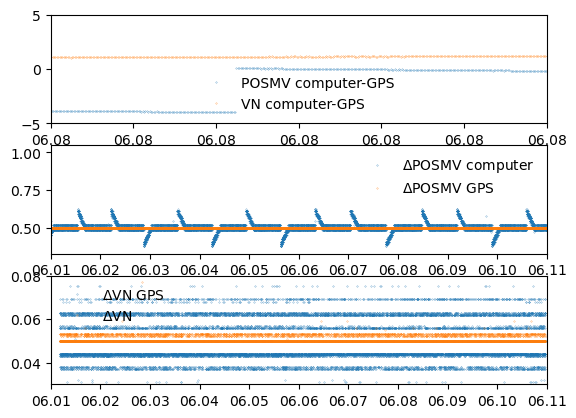

In [39]:
# sanity check POSMV times
pp = eachindex(pgdt)[1:120:end]
vv = eachindex(vndt)[1:1200:end]

clf()
subplot(3,1,1)
plot(pgdt[pp], DVS.(pcdt.-pgdt)[pp], marker=".", markersize=0.4, linestyle="none", label="POSMV computer-GPS")
# plot(pgdt[pp], DVS.(padt.-pgdt)[pp], marker=".", markersize=0.4, linestyle="none", label="POSMV adjusted-GPS")
plot(vngdt[vv], DVS.(vndt.-vngdt)[vv], marker=".", markersize=0.4, linestyle="none", label="VN computer-GPS")
ylim([-5, 5])
xlim([DateTime(2024,6,1), DateTime(2024,6,11)])
xlim([DateTime(2024,6,8,3), DateTime(2024,6,8,9)])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))
legend(frameon=false)
subplot(3,1,2)
plot(pgdt[pp], DVS.(diff(pcdt))[pp],  marker=".", markersize=0.4, linestyle="none", label=L"\Delta"*"POSMV computer")
plot(pgdt[pp], DVS.(diff(pgdt))[pp],  marker=".", markersize=0.4, linestyle="none", label=L"\Delta"*"POSMV GPS")
# plot(pgdt[pp], DVS.(diff(padt))[pp],  marker=".", markersize=0.4, linestyle="none", label=L"\Delta"*"POSMV adj")
xlim([DateTime(2024,6,1), DateTime(2024,6,11)])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))
legend(frameon=false)
subplot(3,1,3)
plot(vngdt[vv], DVS.(diff(vngdt))[vv], marker=".", markersize=0.4, linestyle="none", label=L"\Delta"*"VN GPS")
plot(vngdt[vv], DVS.(diff(vndt) )[vv],  marker=".", markersize=0.4, linestyle="none", label=L"\Delta"*"VN")
ylim([0.03, 0.08])
xlim([DateTime(2024,6,1), DateTime(2024,6,11)])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))
legend(frameon=false)
gcf()

# both the computer and the adjusted time drift and reset.
# what if the GPS time is drifting off the real time and resetting? But it's increments are nearly constant!

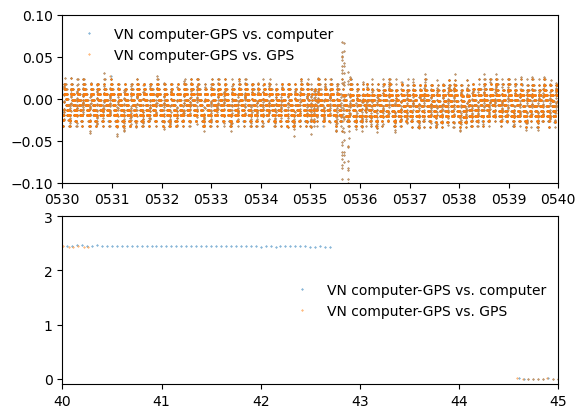

In [116]:
clf()
subplot(2,1,1)
vv = findall(DateTime(2024,6,6,4) .<= vndt .<= DateTime(2024,6,6,8))
# plot(pgdt[pp], DVS.(pcdt.-pgdt)[pp], marker=".", markersize=0.4, linestyle="none", label="POSMV computer-GPS")
plot(vndt[vv], DVS.(vndt.-vngdt)[vv], marker=".", markersize=0.7, linestyle="none", label="VN computer-GPS vs. computer")
plot(vngdt[vv], DVS.(vndt.-vngdt)[vv], marker=".", markersize=0.7, linestyle="none", label="VN computer-GPS vs. GPS")
ylim([-0.1, 0.1])
xlim([DateTime(2024,6,6,5,30), DateTime(2024,6,6,5,40)])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H%M"))
legend(frameon=false)

subplot(2,1,2)
vv = findall(DateTime(2024,6,10,12,58,40) .<= vndt .<= DateTime(2024,6,10,12,59))
# plot(pgdt[pp], DVS.(pcdt.-pgdt)[pp], marker=".", markersize=0.4, linestyle="none", label="POSMV computer-GPS")
plot(vndt[vv], DVS.(vndt.-vngdt)[vv], marker=".", markersize=0.7, linestyle="none", label="VN computer-GPS vs. computer")
plot(vngdt[vv], DVS.(vndt.-vngdt)[vv], marker=".", markersize=0.7, linestyle="none", label="VN computer-GPS vs. GPS")
ylim([-0.1, 3])
xlim([DateTime(2024,6,10,12,58,40), DateTime(2024,6,10,12,58,45)])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%S"))
legend(frameon=false)
gcf()

POSMV GPS looks good. Maybe the logging keys on the GPS (it seems more regular)
and it actually runs fast, sampling the computer time later and later, resulting 
in the time lag. An adjustment for this would be to dilate the GPS dt, i.e. 
slow it down so it doesn't accumulate such a lead over the computer, that then resets.

POSMV computer clock jitters more than POSMV GPS. This jitter seems unrelated to the 
timing of drifts and resets.

VN GPS clock jitters more than $\Delta$ VNcomputer.

06.06 06:00 either the VN GPS clock starts to run slow, 
or the VN computer clock runs fast. Even if the VN computer runs fast 
the $\Delta$ VN appears constant
because it controls the sampling, but the PDF of the $\Delta$ GPS shifts
smaller, allowing the computer clock to accumulate faster than the GPS clock.

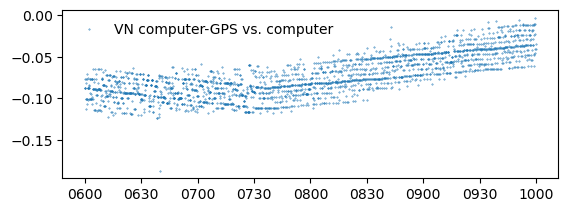

In [155]:
clf()
subplot(2,1,1)
vv = findall(DateTime(2024,5,11,6) .<= vndt .<= DateTime(2024,5,11,10))[1:120:end]
# plot(pgdt[pp], DVS.(pcdt.-pgdt)[pp], marker=".", markersize=0.4, linestyle="none", label="POSMV computer-GPS")
plot(vndt[vv], DVS.(vndt.-vngdt)[vv], marker=".", markersize=0.7, linestyle="none", label="VN computer-GPS vs. computer")
# plot(vngdt[vv], DVS.(vndt.-vngdt)[vv], marker=".", markersize=0.7, linestyle="none", label="VN computer-GPS vs. GPS")
# ylim([-0.1, 0.1])
# xlim([DateTime(2024,6,6,5,30), DateTime(2024,6,6,5,40)])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H%M"))
legend(frameon=false)

# subplot(2,1,2)
# vv = findall(DateTime(2024,6,10,12,58,40) .<= vndt .<= DateTime(2024,6,10,12,59))
# # plot(pgdt[pp], DVS.(pcdt.-pgdt)[pp], marker=".", markersize=0.4, linestyle="none", label="POSMV computer-GPS")
# plot(vndt[vv], DVS.(vndt.-vngdt)[vv], marker=".", markersize=0.7, linestyle="none", label="VN computer-GPS vs. computer")
# plot(vngdt[vv], DVS.(vndt.-vngdt)[vv], marker=".", markersize=0.7, linestyle="none", label="VN computer-GPS vs. GPS")
# ylim([-0.1, 3])
# xlim([DateTime(2024,6,10,12,58,40), DateTime(2024,6,10,12,58,45)])
# gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%S"))
# legend(frameon=false)
gcf()

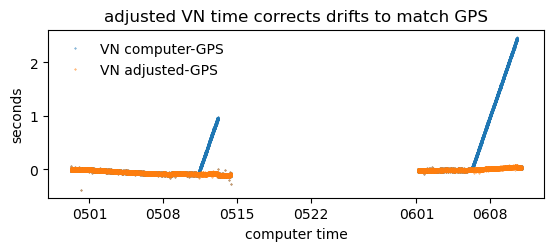

In [166]:
long_drift_cmp_time = DateTime(2024,6,10,12,58,42,700) - DateTime(2024,6,6,5,32)
long_drift_gps_time = DateTime(2024,6,10,12,58,40,300) - DateTime(2024,6,6,5,32)
end_offset = long_drift_cmp_time - long_drift_gps_time # = Millisecond(2400)

time_factor = long_drift_gps_time/long_drift_cmp_time # < 1
1-time_factor # 6.4e-6

"piecewise time adjustment function for VN computer time between t0 t1"
function adj_vn_dt(vndt; t0::DateTime, t1::DateTime, time_factor::Real)
    t = copy(vndt)
    i0 = findfirst(vndt .>= t0)
    i1 = findlast( vndt .<= t1)
    tadd = @. Millisecond( round(Integer, time_factor*Dates.value(vndt[i0:i1]-t0)) )
    t[i0:i1] .= t0 .+ tadd
    return t
end

t0 = DateTime(2024,6,6,5,32)
t1 = DateTime(2024,6,10,12,58,42,700)
tadj = adj_vn_dt(vndt; t0=t0, t1=t1, time_factor=time_factor)
t0 = DateTime(2024,5,11,7,30)
t1 = DateTime(2024,5,13,3,58,43,500)
vnadt = adj_vn_dt(tadj; t0=t0, t1=t1, time_factor=time_factor)

clf()
subplot(2,1,1)
vv = findall(vndt.>DateTime(1980))[1:1200:end]
plot(vndt[vv], DVS.(vndt.-vngdt)[vv], marker=".", markersize=0.7, linestyle="none", label="VN computer-GPS")
plot(vndt[vv], DVS.(vnadt.-vngdt)[vv], marker=".", markersize=0.7, linestyle="none", label="VN adjusted-GPS")
xlabel("computer time")
ylabel("seconds")
title("adjusted VN time corrects drifts to match GPS")
# plot(vngdt[vv], DVS.(vndt.-vngdt)[vv], marker=".", markersize=0.7, linestyle="none", label="VN computer-GPS vs. GPS")
# ylim([-0.1, 0.1])
# xlim([DateTime(2024,6,6,5,30), DateTime(2024,6,6,5,40)])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m%d"))
legend(frameon=false)
gcf()

In [ ]:
# The POSMV GPS time does not seem to be resetting. 
# It's highly regular at dt=0.5 s; 0.4% (29167) dt=0.501; 2 steps of dt=0.505;
# 12 timesteps are skipped giving dt=1.00[1];
# and there's the several day leg 1 - leg 2 gap.

# Rather, it must be the POSMV computer clock that is resetting and recorded with more jitter.
# Hence, use the POSMV GPS time: 
# pgdt = timing_lidar.pashr_gps_datetime.(Pashr[:time], Pashr[:gpstime])

In [34]:
"midpoint interpolate the skipped points"
function midint!(x, jskipmid)
    @. x[jskipmid] = 0.5 * ( x[jskipmid-1] + x[jskipmid+1] )
end

"make a series fill x with pgdt but open up gaps at pgdt[skip1]"
function opengaps!(x, pgdt, skip1)
    for i in eachindex(pgdt)
        c = sum( skip1 .< i )
        j = i + c
        x[j] = pgdt[i]
    end
end

"fill in skipped timesteps where there is 1 s rather than 0.5 s between timesteps"
function fill_skipped_times(pgdt, data; dt=0.5)
    isskips = 0.9*2*dt .< DVS.(diff(pgdt)) .< 1.1*2*dt
    DVS.(diff(pgdt))[isskips]
    skip1 = findall(isskips)
    skip2 = skip1 .+ 1

    # index expanded array w/o skips into original array with skips
    x = zeros(eltype(pgdt), length(pgdt) + length(skip1) )
    opengaps!(x, pgdt, skip1)
    y = zeros(eltype(data), length(pgdt) + length(skip1) )
    opengaps!(y, data, skip1)

    jskipmid = skip1 .+ eachindex(skip1)
    # jskip1 = jskipmid .- 1 
    # jskip2 = jskipmid .+ 1
    
    @. x[jskipmid] = x[jskip1] + Millisecond(500)
    # interpolate the skipped points
    # midint!(x, jskipmid) # doesn't work for DateTimes
    midint!(y, jskipmid)
    return x, y, jskipmid
end

# filled even time coordinate
posmvdt, Ppitch, jskip = fill_skipped_times(pgdt, Pashr[:pitch]) 
# itp = interpolate(, BSpline(Linear()))

# test
all( posmvdt[jskip1] .== pgdt[skip1] ) # true passes
any(0.9 .< DVS.(diff(posmvdt)) .< 60.0) # false passes
minimum(DVS.(diff(posmvdt))), maximum(DVS.(diff(posmvdt))[DVS.(diff(posmvdt)).<3000])
# clf()
# plot(DVS.(diff(posmvdt))[DVS.(diff(posmvdt)).<5000]) # all between 0.500 - 0.0505 passes
# gcf()
# clf()
# plot(posmvdt, Ppitch) # all between 0.500 - 0.0505 passes
# plot(posmvdt[jskipmid], Ppitch[jskipmid], marker=".", linestyle="none") # all between 0.500 - 0.0505 passes
# gcf()

# nice regular 0.5 s coordinate

UndefVarError: UndefVarError: `jskip1` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [35]:
# deprecated: Explore old posmvdt time coordinate
#=
posmvdt = Pashr[:posmvdt] # UTC convention
# indices of unique types of gaps
idrop =  findall( Millisecond(680) .< diff(posmvdt) .< Second(2) )
ireset = findall( Second(2)        .< diff(posmvdt) .< Hour(1) )
ileg =   findall( Hour(1)          .< diff(posmvdt)  )
# findall(diff(posmvdt) .< Millisecond(0)) # none

length(idrop), length(ireset), length(ileg), length(pmvdt), length(posmvdt)
diff(posmvdt)[idrop] # 1000 ± 16 ms
diff(posmvdt)[ireset] # 2600, 3200, 3300, 3800, 4500 ms

# posmvdt1 = posmvdt[1]:Millisecond(500):posmvdt[igap]
# posmvdt2 = posmvdt[igap+1]:Millisecond(500):posmvdt[end]
# pmvdt = vcat(posmvdt1,posmvdt2)
# diff(posmvdt)[idrop]
=#

In [36]:
# load time coordinates, window time series methods

# REPLACE posmvdt with POSMV GPS time, which is probably more reliable :: 2025 Feb 12
# posmvdt = Pashr[:posmvdt] # UTC convention
# posmvdt = Pashr[:time] # UTC convention
# posmvdt = timing_lidar.pashr_gps_datetime.(Pashr[:time], Pashr[:gpstime]) # UTC convention
# use filled posmvdt above
vndt = Vn[:vndt]          # GPS convention

"""
posmv and vectornav indices for requested UTC DateTime start and epoch length TimePeriod
daylimits(posmvdt, vndt, utcdt::DateTime=DateTime(2024,6,1,6,0,0), epoch::Period=Minute(3), leapseconds=18)
"""
function daylimits(posmvdt, vndt, utcdt::DateTime=DateTime(2024,6,1,6,0,0), epoch::Period=Minute(3), leapseconds=18)
    post = findfirst( posmvdt .>= utcdt )
    poen = findlast(  posmvdt .<= utcdt + epoch )
    vnst = findfirst( vndt    .>= utcdt + Second(leapseconds) ) # view +18 leapseconds forward to agree with UTC
    vnen = findlast(  vndt    .<= utcdt + Second(leapseconds) + epoch )
    post, poen, vnst, vnen
end

"default daylimits method uses POSMV GPS time, VN computer time"
daylimits(utcdt::DateTime=DateTime(2024,6,1,6,0,0), epoch::Period=Minute(3), leapseconds=18) =
    daylimits(posmvdt, vndt, utcdt, epoch, leapseconds)

daylimits

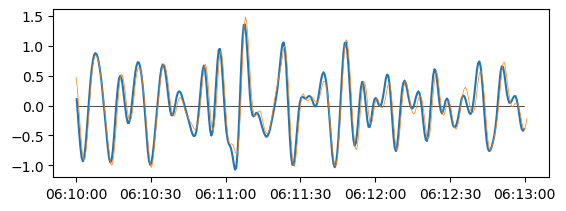

In [76]:
# sync time series

sample_factor = 10 #9.933333 # 9.95 not quite 10 = 20 Hz / 2 Hz
# Vn actually samples slightly slower than 10x the speed of POSMV
# so stepping by 10 Vn gets ahead of alignment with POSMV.
# Need to advance one index less (9 rather than 10) every 167 samples

# example time series synced by hand in vectornav.ipynb
post, poen, vnst, vnen = daylimits(DateTime(2024,6,1,6,10,0), Minute(3)) # June 1 1st day of Vn2
# this example window has a lag of ~20 s (`vectornav.ipynb`) 
# subtract 20 s from vndt to match same signal at same time
# indices vnst:vnen already shift for the 18 GPS leapseconds;
# at this time, need to shift forward 40 indices for the 2 s.
vn_offset = 48
# indices for Vn that line up with POSMV
vv = round.(Integer, range(vn_offset+vnst, step=sample_factor, length=poen-post+1))
pp = post:poen
# plot demonstrates that it's synced
clf()
subplot(2,1,1)
plot(posmvdt[[post, poen]], [0,0], color="k", linewidth=0.5)
plot(posmvdt[post:poen], anom(Pashr[:pitch][post:poen]), label="POSMV pitch") # blue
plot(vndt[vv]-Second(18)-Millisecond(50*vn_offset), anom(Vn[:Roll][vv]), label="VectorNav roll", linewidth=0.5)
# plot(posmvdt[post:poen], 100.0 .*θrate[post:poen], label="rate", linewidth=0.5)
# plot(posmvdt[post:poen], 100.0 .*anom(θrate[post:poen]), label="rate")
gcf()


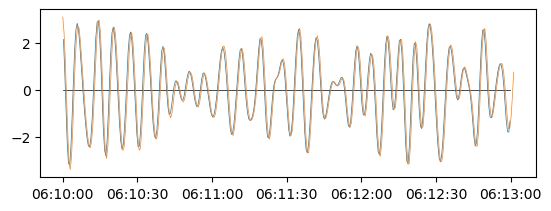

In [ ]:
# window and sync time series

# VN time offset = leapseconds + vn_offset/20 seconds
post, poen, vnst, vnen = daylimits(DateTime(2024,6,10,6,10,0), Minute(3)) # June 1 1st day of Vn2
vn_offset = 2 # 6 # vn index steps
# indices vnst:vnen already shift for the 18 GPS leapseconds;
# at this time, need to shift forward 40 indices for the 2 s.

# indices for Vn that line up with POSMV - same as above cell
vv = round.(Integer, range(vnst+vn_offset, step=sample_factor, length=poen-post+1))
pp = post:poen
# plot demonstrates that it's synced
# this diagnostic is different than shifting the time as in vectornav.ipynb
clf()
subplot(2,1,1)
plot(posmvdt[[post, poen]], [0,0], color="k", linewidth=0.5)
plot(posmvdt[post:poen], anom(Pashr[:pitch][post:poen]), label="POSMV pitch", linewidth=0.5) # blue
plot(vndt[vv]-Second(18)-Millisecond(50*vn_offset), anom(Vn[:Roll][vv]), label="VectorNav roll", linewidth=0.5)
# plot(posmvdt[post:poen], 100.0 .*θrate[post:poen], label="rate", linewidth=0.5)
# plot(posmvdt[post:poen], 100.0 .*anom(θrate[post:poen]), label="rate", linewidth=0.5)
gcf()


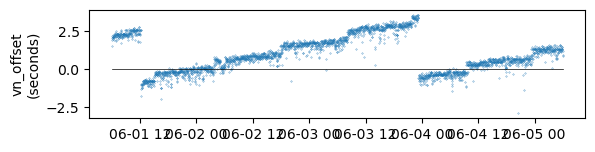

In [30]:
# test automatic lag finding in part of leg 2

factor = 10        # hi/lo sample rate
epoch_length = 480 # lo-freq samples, 4 min windows
initial_guess = 0
window = 90
wideoffset = 8 # s
start_idx = 2*wideoffset # corresp to ±4 s possible offsets 

# calculate lag every 10 min
dts = (DateTime(2024,6,1,6,0,)-Second(wideoffset)):Minute(2):(DateTime(2024,6,5,6,0,0)+Second(wideoffset))

optlag = zeros(Int32, length(dts))
for (i, dt) in enumerate(dts)
    (post, poen, vnst, vnen) = daylimits(dt, Minute(5)) # 5 m window epoch
    low_freq_series = Pashr[:pitch][post:poen]
    high_freq_series = Vn[:Roll][vnst:vnen]
    initial_guess = grid_search(high_freq_series, low_freq_series, factor, start_idx, epoch_length, initial_guess, window)
    optlag[i] = initial_guess
end # works

clf()
subplot(3,1,1)
plot(dts, 0.05*optlag, marker=".", markersize=0.5, linestyle="none")
plot([dts[1], dts[end]], [0,0], color="k", linewidth=0.5)
# xlim([DateTime(2024,4,29), DateTime(2024,6,15,12)])
ylabel("vn_offset\n(seconds)")
gcf()

# consistently about -.5 s

In [31]:
# calculate lag every 1 min for both legs 1 and 2 !SLOW!
#=
VectorNav leg 1
2024-04-29T05:25:42.128
2024-05-14T10:00:32.927
VectorNav leg 2
2024-06-01T04:18:42.098
2024-06-10T23:25:22.772
POSMV leg 1
2024-04-30T00:00:01.868
2024-05-13T13:43:50.852
POSMV leg 2
2024-05-17T22:53:24.908
2024-06-13T07:17:40.050
=#

if true # do the slow lag calculations
    # SLOW
    dts1 = (DateTime(2024, 4,30, 0,10,0)-Second(wideoffset)):Minute(1):(DateTime(2024, 5,13,13,40,0)+Second(wideoffset))
    dts2 = (DateTime(2024, 6, 1, 4,20,0)-Second(wideoffset)):Minute(1):(DateTime(2024, 6,10,23,20,0)+Second(wideoffset))
    dts = vcat(dts1, dts2)
    optlag = zeros(Int32, length(dts))

    # syncing parameters
    sample_factor = 10        # hi/lo sample rate
    epoch_length = 120 # lo-freq samples, 2 min windows
    initial_guess = 0
    window = 90
    wideoffset = 4 # s
    start_idx = 2*wideoffset # corresp to ±4 s possible offsets 

    # (post, poen, vnst, vnen) = daylimits(dts[i], Second(90)) # must be > epoch_length/2 ?
    #     optlag[i] = grid_search(Vn[:Roll][vnst:vnen], Pashr[:pitch][post:poen], 
    #         sample_factor, start_idx, epoch_length, initial_guess, window)

    for (i, dt) in enumerate(dts)
        (post, poen, vnst, vnen) = daylimits(dt, Second(90)) # must be > epoch_length/2 ?
        optlag[i] = grid_search(Vn[:Roll][vnst:vnen], Pashr[:pitch][post:poen], 
            sample_factor, start_idx, epoch_length, initial_guess, window)
        initial_guess = round(Int32, optlag[i] / 2)
    end

    OptLag = Dict("dt"=>dts, "optimum_vn_lag"=>optlag, 
    "eg_formula"=>"Vn[:Pitch][round.(Integer, range(vn_offset + vnst, step = sample_factor, length = (poen - post) + 1))]")
    save("optimum_vn_lag_20250213.jld2", "optlag", OptLag) # easier if it has the name "optlag" for the dict within the file
else
    OptLag = load("optimum_vn_lag_20250213.jld2")["optlag"] # loads the Dict
end

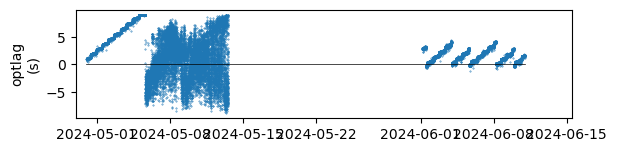

In [32]:
# plot the optimum lags
clf()
subplot(3,1,1)
plot(dts, 0.05*optlag, marker=".", markersize=0.7, linestyle="none")
plot([dts[1], dts[end]], [0,0], color="k", linewidth=0.5)
xlim([DateTime(2024,4,29), DateTime(2024,6,15,12)])
# xlim([DateTime(2024,4,30,3,15), DateTime(2024,4,30,3,45)])
ylabel("optlag\n(s)")
gcf()
# looks great!

The POSMV computer clock or the POSMV clock corrected to the GPS clock are not effective time coordinates. POSMV GPS time is good.

The lag between POSMV is close to constant. Some precession from negative to and jitter, but not secular drifts.

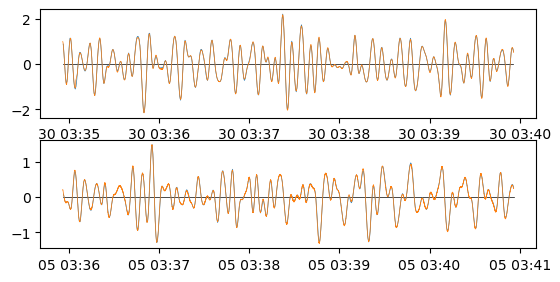

In [74]:
ind = findall(abs.((dts.+Second(4)) .- DateTime(2024,4,30,3,35)) .< Second(30))[1]
post, poen, vnst, vnen = daylimits(dts[ind], Minute(5))
# vv = round.(Integer, range(optlag[ind]+vnst, step=sample_factor, length=poen-post+1))
vv = (vnst:vnen) #.- optlag[ind]
pp = post:poen

# plot demonstrates that it's synced
clf()
subplot(3,1,1)
plot(posmvdt[[post, poen]], [0,0], color="k", linewidth=0.5)
plot(posmvdt[pp], anom(Pashr[:pitch][pp]), label="POSMV pitch", linewidth=0.5) # blue
# plot(posmvdt[pp], anom(Vn[:Roll][vv]), label="VectorNav roll", linewidth=0.5)
plot(vndt[vv]-Second(18), anom(Vn[:Roll][vv]), label="VectorNav roll", linewidth=0.5)
# plot(posmvdt[post:poen], 100.0 .*θrate[post:poen], label="rate", linewidth=0.5)
# plot(posmvdt[post:poen], 100.0 .*anom(θrate[post:poen]), label="rate", linewidth=0.5)

ind = findall(abs.((dts.+Second(4)) .- DateTime(2024,5,5,3,36)) .< Second(30))[1]
post, poen, vnst, vnen = daylimits(dts[ind], Minute(5))
# vv = round.(Integer, range(optlag[ind]+vnst, step=sample_factor, length=poen-post+1))
vv = (vnst:vnen) #.+ optlag[ind]
pp = post:poen
subplot(3,1,2)
plot(posmvdt[[post, poen]], [0,0], color="k", linewidth=0.5)
plot(posmvdt[pp], anom(Pashr[:pitch][post:poen]), label="POSMV pitch", linewidth=0.5) # blue
# plot(posmvdt[pp], anom(Vn[:Roll][vv]), label="VectorNav roll", linewidth=0.5)
plot(vndt[vv]-Second(18), anom(Vn[:Roll][vv]), label="VectorNav roll", linewidth=0.5)
# plot(posmvdt[post:poen], 100.0 .*θrate[post:poen], label="rate", linewidth=0.5)
# plot(posmvdt[post:poen], 100.0 .*anom(θrate[post:poen]), label="rate", linewidth=0.5)
gcf()


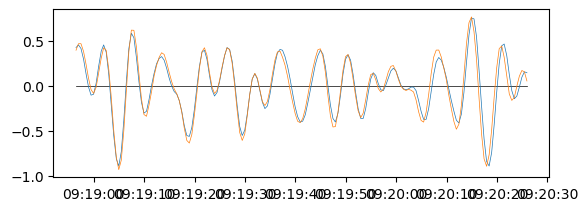

In [44]:
# test plot one minute
i = 200
(post, poen, vnst, vnen) = daylimits(dts[i], Second(90))
vv = round.(Integer, range(optlag[i]+vnst, step=sample_factor, length=poen-post+1))

# plot demonstrates that it's synced
# this diagnostic is different than shifting the time as in vectornav.ipynb
clf()
subplot(2,1,1)
plot(posmvdt[[post, poen]], [0,0], color="k", linewidth=0.5)
plot(posmvdt[post:poen], anom(Pashr[:pitch][post:poen]), label="POSMV pitch", linewidth=0.5) # blue
plot(posmvdt[post:poen], anom(Vn[:Roll][vv]), label="VectorNav roll", linewidth=0.5)
# plot(posmvdt[post:poen], 100.0 .*anom(θrate[post:poen]), label="rate", linewidth=0.5)
gcf()


In [ ]:
# automate and refactor fine tuning of the lag

# calculate lag every 1 min
# parameters
# sample_factor = 9.94
sample_factor = 10
epoch_length = 480 # lo-freq samples, 1 min moving window
initial_guess = 0 # first initial guess
window = 90
wideoffset = 4 # s
start_idx = 2*wideoffset # corresp to ±4 s possible offsets 

function fine_lag(dts, ig0,
    hfs=Vn[:Roll][:], lfs=Pashr[:pitch][:],
    sample_factor=sample_factor, start_idx=start_idx, epoch_length=epoch_length, window=window)

    optlag = zeros(Int32, length(dts))
    initial_guess = ig0
    for (i, dt) in enumerate(dts)
        (post, poen, vnst, vnen) = daylimits(dt, Minute(1)) # 5 m window epoch
        x = grid_search(hfs[vnst:vnen], lfs[post:poen], 
                        sample_factor, start_idx, epoch_length, 
                        initial_guess, window) # returns missing ???
        @show x
        if !ismissing(x)
            initial_guess = x # for next iteration
            optlag[i] = x
        else
            optlag[i] = -999
        end

    end
    return optlag # high frequency series
end

# dts = (DateTime(2024,6,1,6,0,)-Second(wideoffset)):Minute(1):(DateTime(2024,6,5,6,0,0)+Second(wideoffset))
dts = (DateTime(2024,6,1,6,0,0)-Second(wideoffset)):Minute(10):(DateTime(2024,6,1,7,0,0)+Second(wideoffset))
optlag = fine_lag(dts, initial_guess)

plot(dts, optlag)

x = missing
x = missing
x = missing
x = missing
x = missing
x = missing
x = missing


1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x36173d3c0>

In [14]:
# regress moment vector L
M = stack(angle_vec(θ[p], ϕ[p], θrate[p], ϕrate[p]) for p in post:poen)
w = w_lidar[vv] - w_posmv[post:poen] # 360
L = transpose(M) \ anom(w) # regress
# L1 = transpose(anom(w)) / M

# values don't look right, but does solve consistently with slight variations in rotations

3-element Vector{Float64}:
  52.362666425658595
   1.3759890719005334
 151.52052589467326

If pitch is strapped down, but roll is stabilized, 
then set roll $\phi=0$ to rotation matrices ($\sin\phi=0, \cos\phi=1$) into the partly stabilized lidar coordinate system.
Since the ship is still moving, linear velocities at the lidar are still induced by the nonzero pitch and roll angular rates:
    
    V = V_angles(θ, 0, fft_derivative(θ)/dt, fft_derivative(ϕ)/dt)

Clarification:
The VectorNav `VelNED2` measures heave rate in the geographic untilted plumb frame.

*Probably* the POSMV heave is in the geographic plumb frame.

POSMV `heave` is a DISPLACEMENT; differentiate it to get a RATE.